# Stripping Silence

We use this notebook to compare different techniques for cutting silences on the LJ speech dataset.

One of the problems with the Linda John speech dataset, is the the dataset is cut between sentences; therefore, there can be unpredictable silence 

In [1]:
import re
import sys
import random

# Setup the "PYTHONPATH"
sys.path.insert(0, '../')

In [2]:
from IPython.display import display, Audio, Markdown

class UnnormalizedAudio(Audio):

    def _make_wav(self, data, rate):
        """ Transform a numpy array to a PCM bytestring """
        import struct
        from io import BytesIO
        import wave

        try:
            import numpy as np

            data = np.array(data, dtype=float)
            if len(data.shape) == 1:
                nchan = 1
            elif len(data.shape) == 2:
                # In wave files,channels are interleaved. E.g.,
                # "L1R1L2R2..." for stereo. See
                # http://msdn.microsoft.com/en-us/library/windows/hardware/dn653308(v=vs.85).aspx
                # for channel ordering
                nchan = data.shape[0]
                data = data.T.ravel()
            else:
                raise ValueError('Array audio input must be a 1D or 2D array')
            scaled = np.int16(data*32767).tolist()
        except ImportError:
            # check that it is a "1D" list
            idata = iter(data)  # fails if not an iterable
            try:
                iter(idata.next())
                raise TypeError('Only lists of mono audio are '
                    'supported if numpy is not installed')
            except TypeError:
                # this means it's not a nested list, which is what we want
                pass
            scaled = [int(x*32767) for x in data]
            nchan = 1

        fp = BytesIO()
        waveobj = wave.open(fp,mode='wb')
        waveobj.setnchannels(nchan)
        waveobj.setframerate(rate)
        waveobj.setsampwidth(2)
        waveobj.setcomptype('NONE','NONE')
        waveobj.writeframes(b''.join([struct.pack('<h',x) for x in scaled]))
        val = fp.getvalue()
        waveobj.close()

        return val

In [3]:
from src.datasets import lj_speech_dataset
data = lj_speech_dataset(directory='../data', verbalize=False)
random.shuffle(data)

/Users/michaelp/.pyenv/versions/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
100%|██████████| 13100/13100 [00:00<00:00, 13525.46it/s]


In [7]:
%matplotlib inline

from matplotlib import pyplot

def plot_waveform(signals, labels=None):
    """ Plot a wave form
    
    Args:
        signals (list): List of signals to plot.
        labels (list of str, optional): Labels to add to signals.
    """
    pyplot.figure(figsize=(20,5))
    for i, signal in enumerate(signals):
        label = None if labels is None else labels[i]
        pyplot.plot(signal, label=label)
    if labels is not None:
        pyplot.legend()
    pyplot.ylim(-1, 1)
    pyplot.show()

In [11]:
from IPython.display import display, Audio, Markdown
from tqdm import tqdm

import IPython
import numpy as np

from src.audio import read_audio


def evaluate_trim(trim, max_rows=1000, max_samples=5000, top_k=5):
    """ Evaluate a silence trimming algorithm.
    
    Args:
        max_rows (int): Maximum rows to evaluate.
        max_samples (int): Maximum samples to display at the end and beginning of the signal.
        top_k (int): Top k signals to display.
    """
    results = []
    for row in tqdm(data[:max_rows]):
        signal, sample_rate = librosa.core.load(row['wav_filename'], sr=24000)
        trimmed = trim(row['wav_filename'], signal)
        length_difference = len(signal) - len(trimmed)
        if length_difference > 0:
            energy_difference =  (np.sum(np.absolute(signal)) - np.sum(np.absolute(trimmed))) / length_difference
            results.append({'signal_start': np.array(signal[:max_samples]),
                            'signal_end': np.array(signal[-max_samples:]),
                            'trimmed_start': np.array(trimmed[:max_samples]),
                            'trimmed_end': np.array(trimmed[-max_samples:]),
                            'energy_difference': energy_difference,
                            'length_difference': length_difference,
                            'filename': row['wav_filename'],
                            'text': row['text']})

    results = sorted(results, key=lambda r: r['energy_difference'], reverse=True)
    display(Markdown('### Top %d Signals Affected by Trim' % top_k))
    for result in (results[:top_k]):
        display(Markdown('File: %s' % (result['filename'],)))
        display(Markdown('Text: %s' % (result['text'],)))
        display(Markdown('Energy Difference: %f' % (result['energy_difference'],)))
        display(Markdown('Length Difference: %d' % (result['length_difference'],)))
        
        if (np.sum(result['trimmed_start']) - np.sum(result['signal_start'])) != 0:
            display(Markdown('Trimmed Start:'))
            display(UnnormalizedAudio(result['trimmed_start'], rate=sample_rate))
            plot_waveform([result['trimmed_start']])

            display(Markdown('Signal Start:'))
            display(UnnormalizedAudio(result['signal_start'], rate=sample_rate))
            plot_waveform([result['signal_start']])

        if (np.sum(result['trimmed_end']) - np.sum(result['signal_end'])) != 0:
            display(Markdown('Trimmed End:'))
            display(UnnormalizedAudio(result['trimmed_end'], rate=sample_rate))
            plot_waveform([result['trimmed_end']])

            display(Markdown('Signal End:'))
            display(UnnormalizedAudio(result['signal_end'], rate=sample_rate))
            plot_waveform([result['signal_end']])
        display(Markdown('---'))

## Librosa

100%|██████████| 13100/13100 [00:50<00:00, 257.07it/s]


### Top 20 Signals Affected by Trim

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ003-0145-24000.wav

Text: or about a foot and a half laterally. These fees were in reality a substantial contribution towards the expenses of the jail;

Energy Difference: 0.001549

Length Difference: 29

Trimmed End:

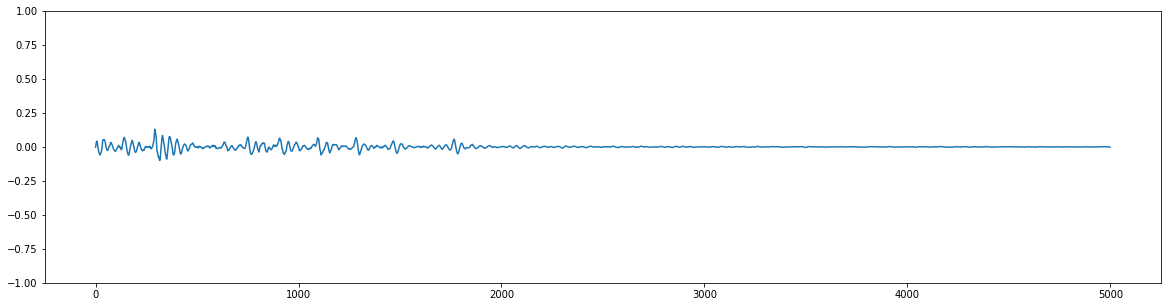

Signal End:

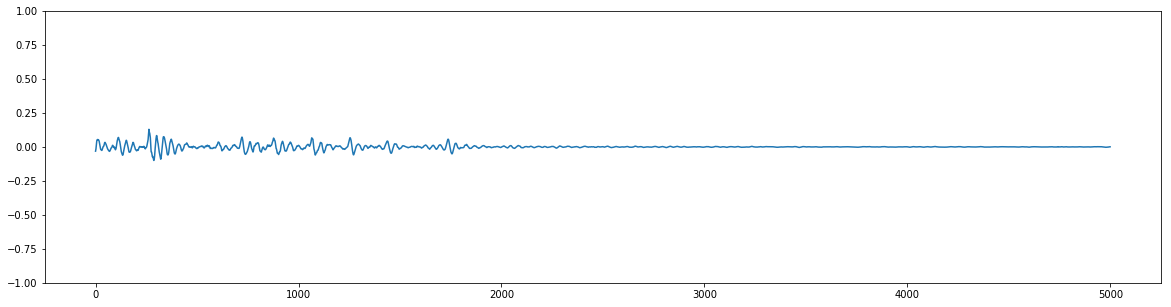

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ012-0142-24000.wav

Text: and implicated "Money Moses," another Jew, for the whole affair had been planned and executed by members of the Hebrew persuasion.

Energy Difference: 0.001395

Length Difference: 7

Trimmed End:

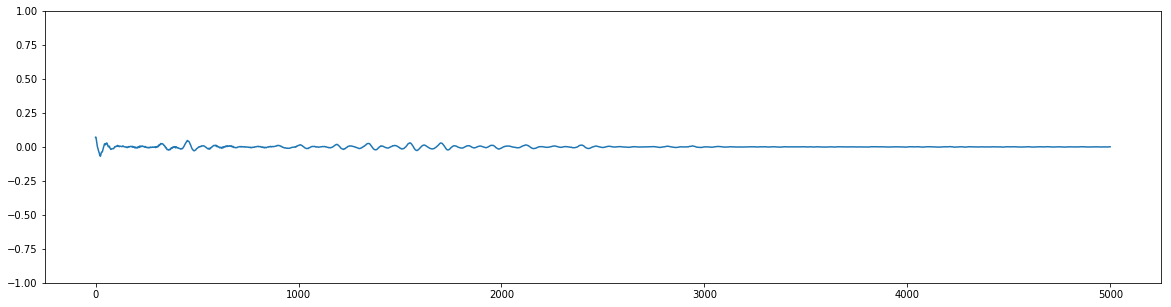

Signal End:

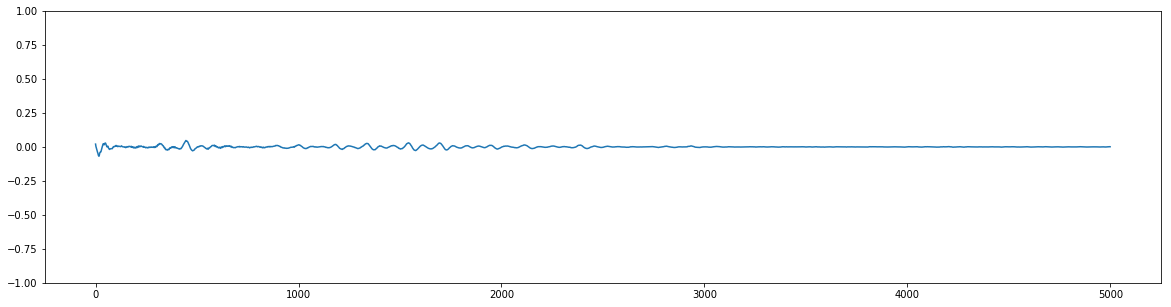

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ006-0053-24000.wav

Text: and the whole by proper management might have been so accommodated as to prevent overcrowding.

Energy Difference: 0.001141

Length Difference: 95

Trimmed End:

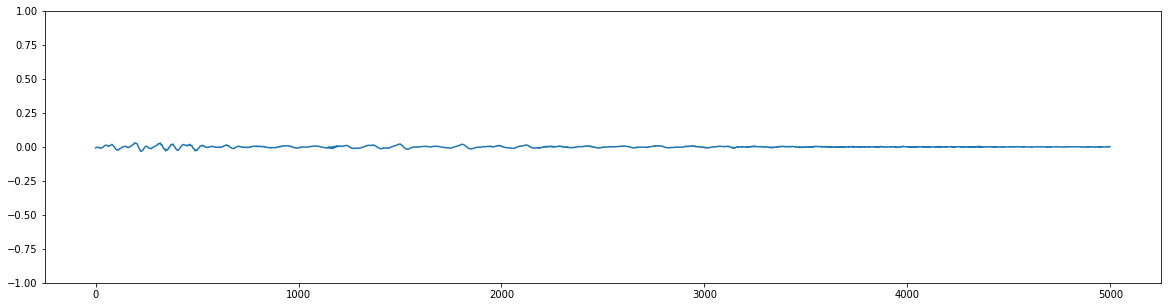

Signal End:

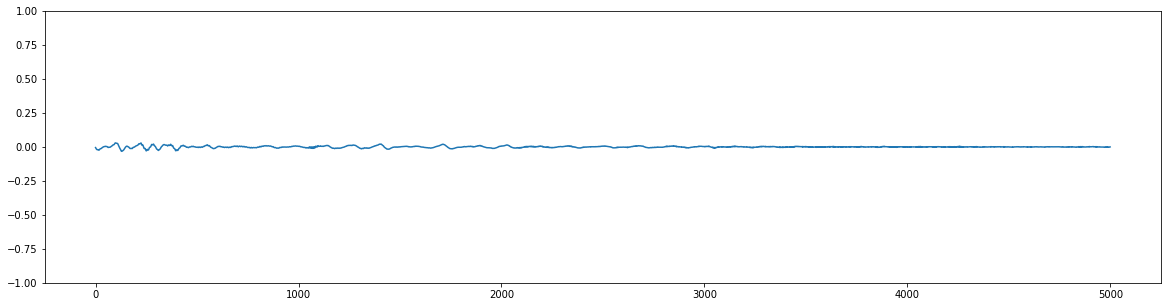

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ012-0018-24000.wav

Text: One of the most notorious, and for a time most successful practitioners in this illicit trade, passed through Newgate in 1831.

Energy Difference: 0.000987

Length Difference: 97

Trimmed End:

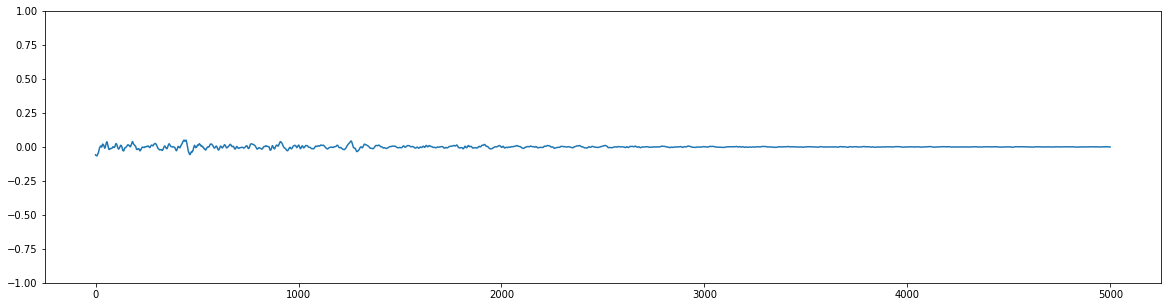

Signal End:

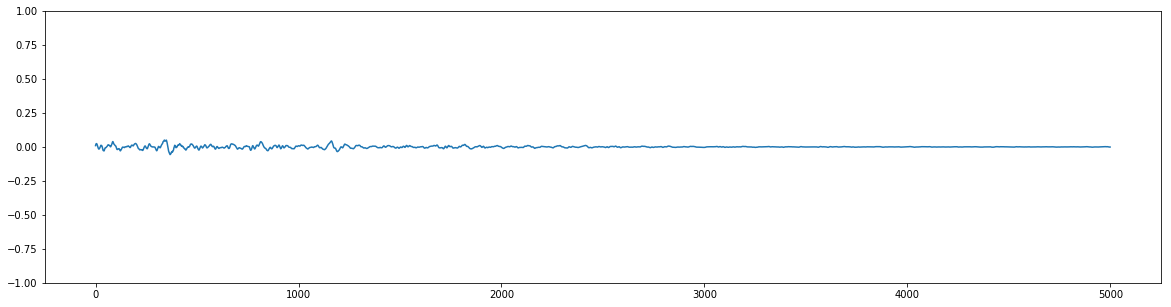

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ001-0087-24000.wav

Text: for the seventeenth-century letters are at least pure and simple in line. The Italian, Bodoni, and the Frenchman, Didot,

Energy Difference: 0.000977

Length Difference: 5

Trimmed End:

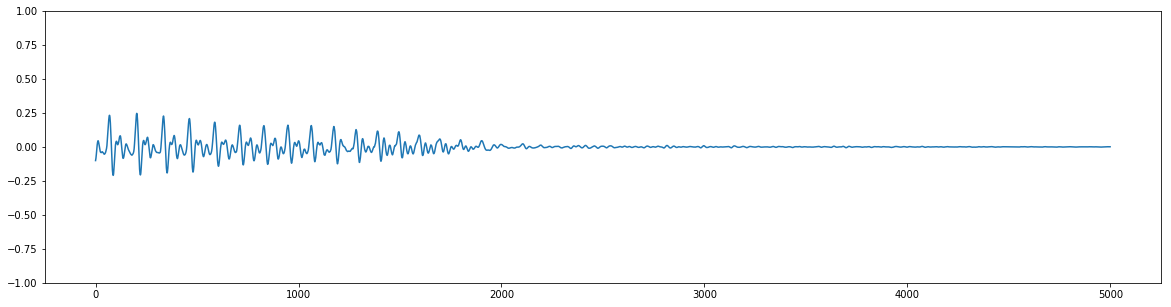

Signal End:

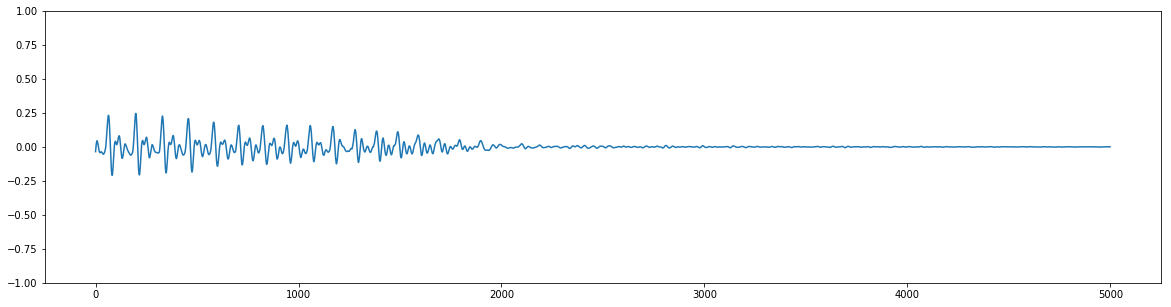

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ019-0342-24000.wav

Text: So was the employment of prisoners in any position of trust or authority;

Energy Difference: 0.000977

Length Difference: 5

Trimmed End:

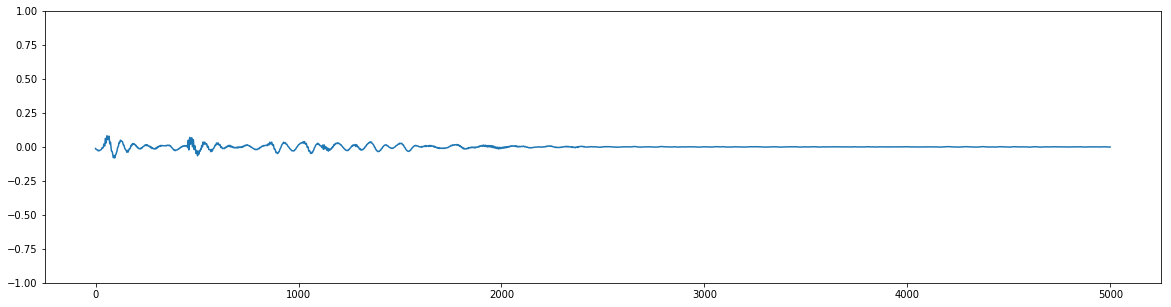

Signal End:

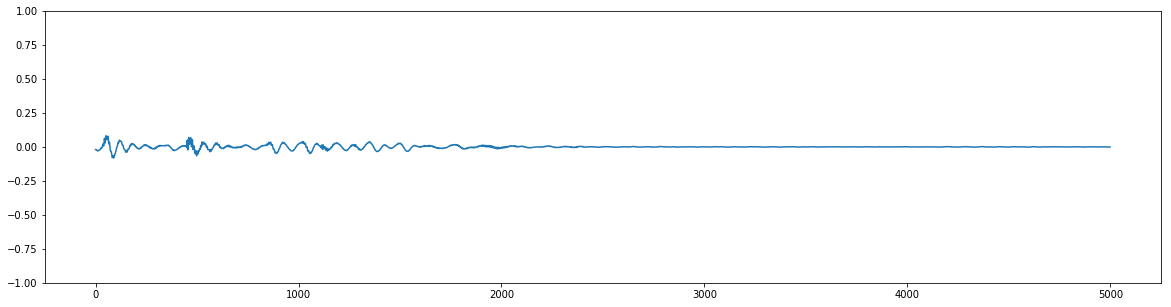

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ028-0253-24000.wav

Text: The city was spared; the great walls were left standing; the daily sacrifices were continued in the temples, and Cyrus made his home in the royal palace.

Energy Difference: 0.000963

Length Difference: 292

Trimmed End:

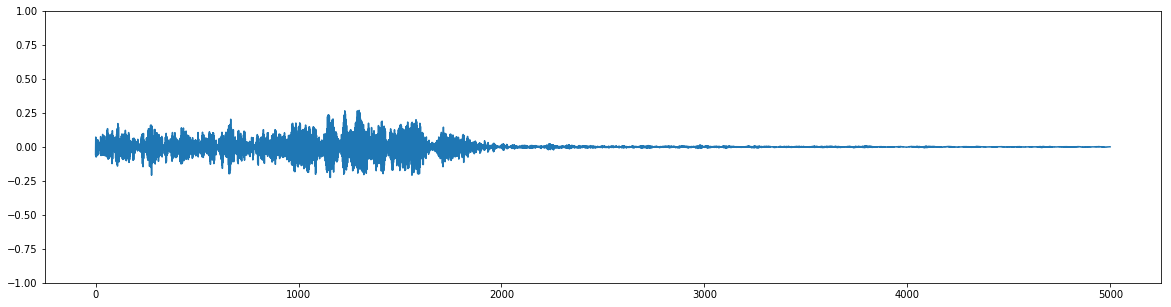

Signal End:

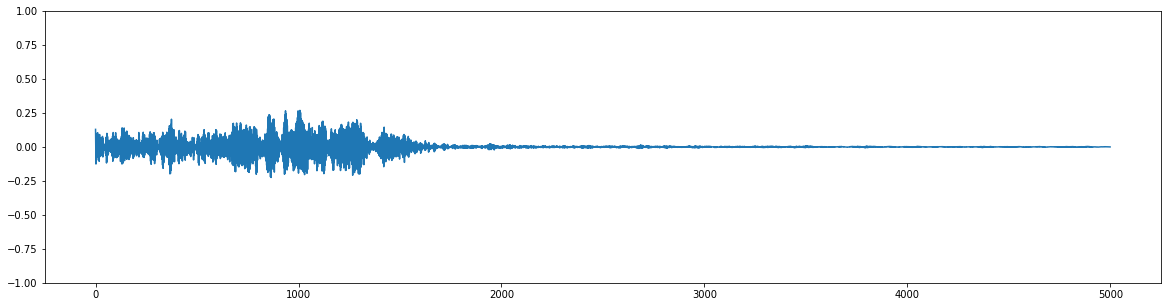

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ045-0230-24000.wav

Text: when he was finally apprehended in the Texas Theatre. Although it is not fully corroborated by others who were present,

Energy Difference: 0.000947

Length Difference: 663

Trimmed End:

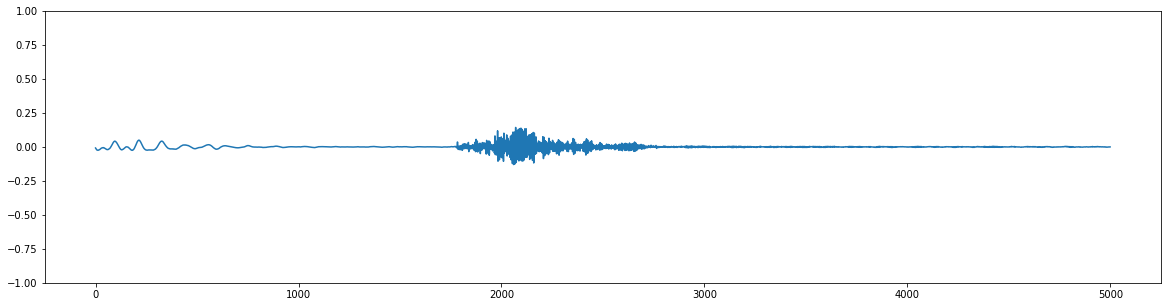

Signal End:

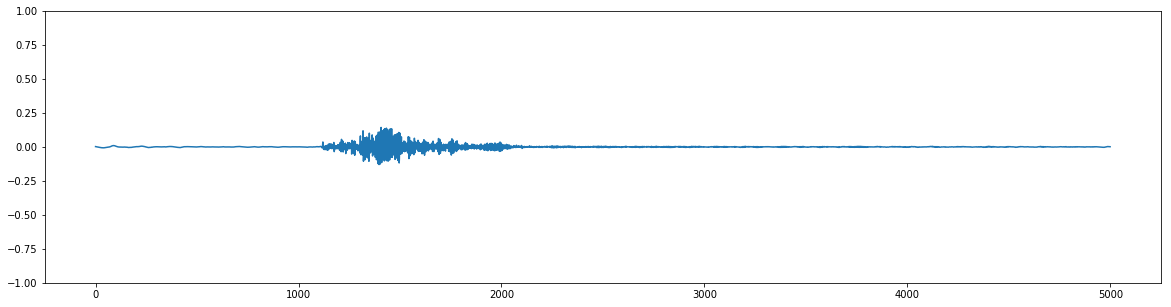

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ015-0173-24000.wav

Text: Warrants were issued for Redpath's arrest, but he had flown to Paris.

Energy Difference: 0.000933

Length Difference: 371

Trimmed End:

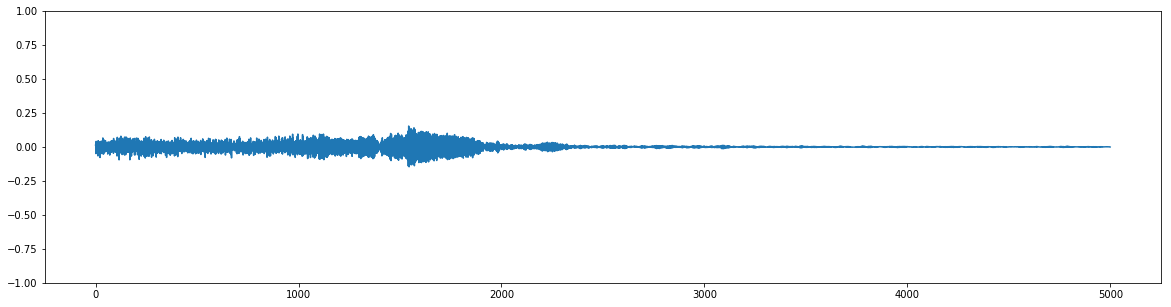

Signal End:

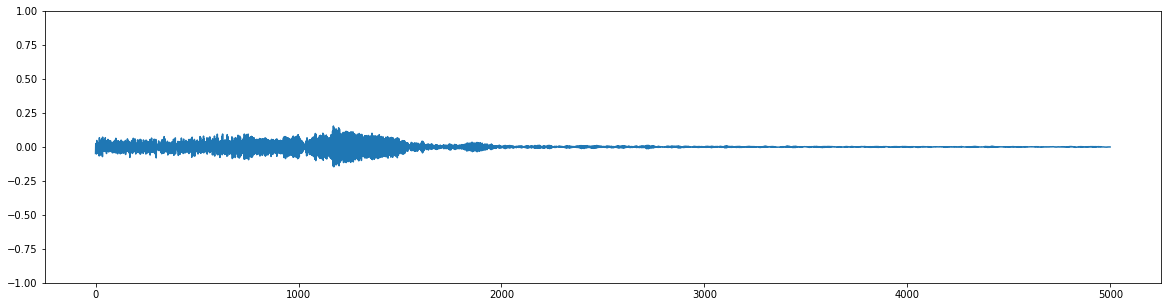

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ001-0003-24000.wav

Text: For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process

Energy Difference: 0.000926

Length Difference: 699

Trimmed End:

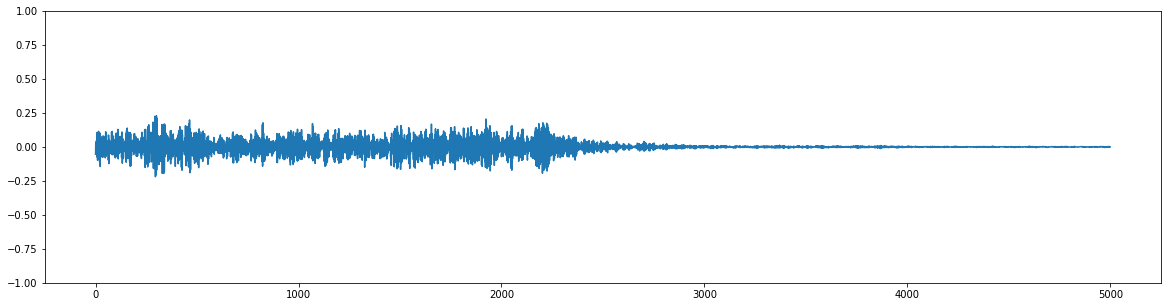

Signal End:

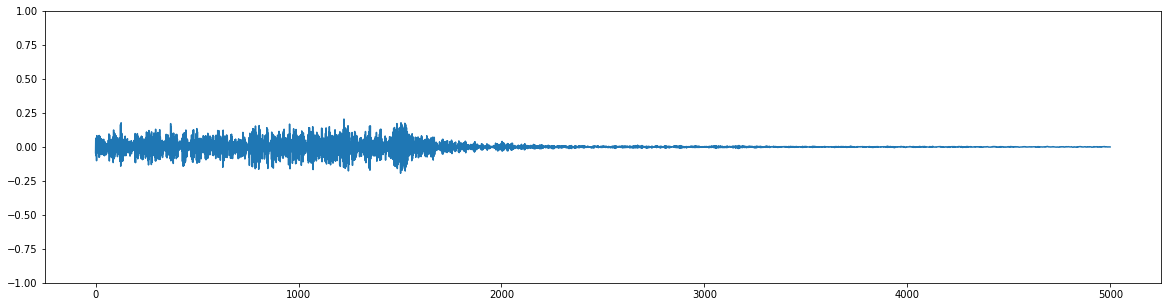

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ018-0242-24000.wav

Text: The case was tried at Guildford Assizes, and caused intense excitement,

Energy Difference: 0.000916

Length Difference: 8

Trimmed End:

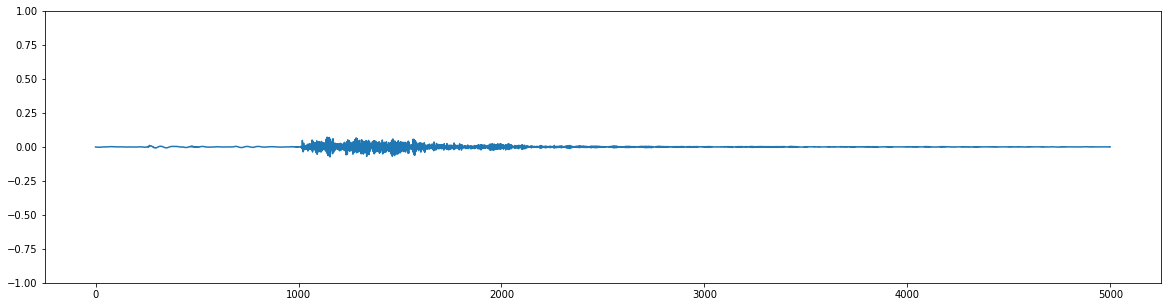

Signal End:

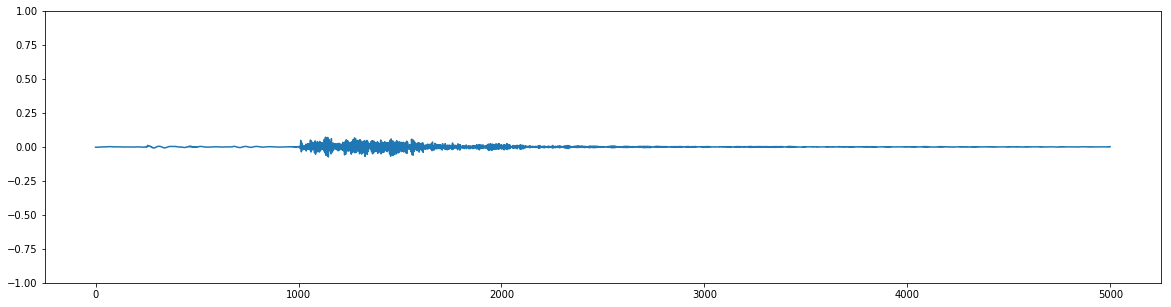

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ020-0016-24000.wav

Text: it is well to stir into the yeast a bit of soda no larger than a grain of corn already wet up in a teaspoonful of boiling water.

Energy Difference: 0.000911

Length Difference: 75

Trimmed End:

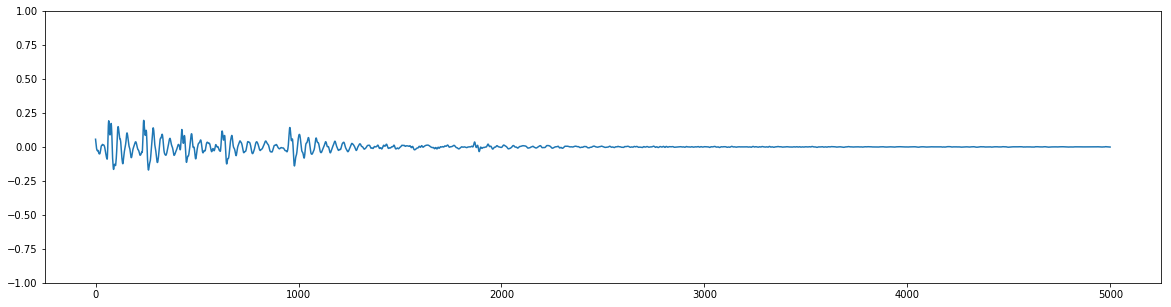

Signal End:

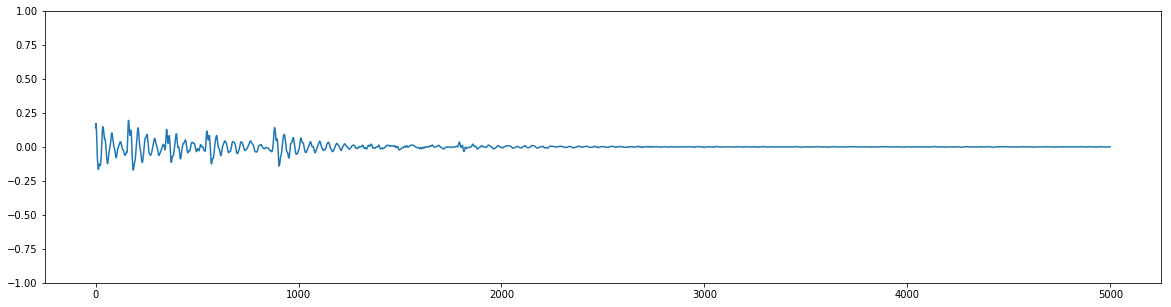

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ046-0098-24000.wav

Text: The history of Presidential protection shows growing recognition over the years that the job must be done by able, dedicated,

Energy Difference: 0.000905

Length Difference: 34

Trimmed End:

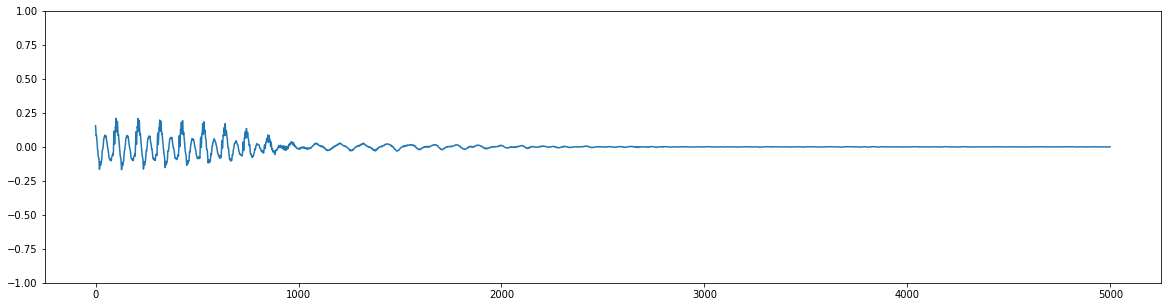

Signal End:

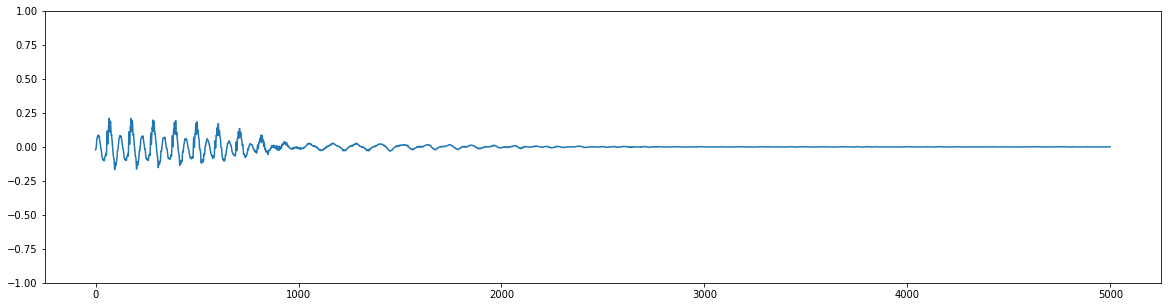

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ044-0061-24000.wav

Text: there also seems to be no basis for his claim that he had distributed, quote,

Energy Difference: 0.000902

Length Difference: 118

Trimmed End:

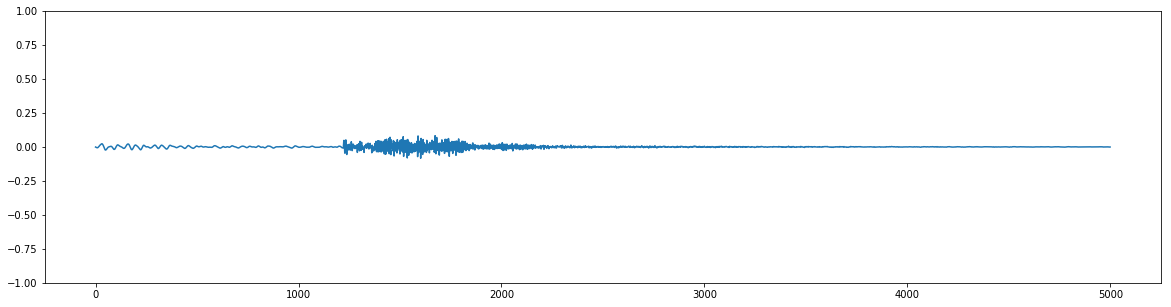

Signal End:

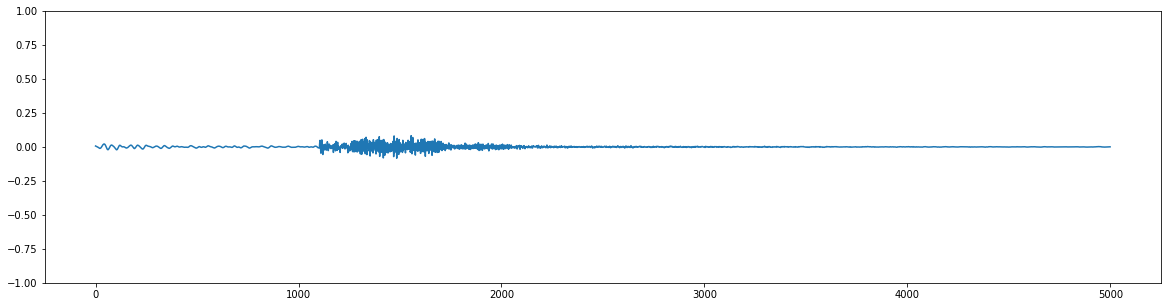

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ006-0139-24000.wav

Text: Nobody interfered with them or regulated their conduct. They might get drunk when so disposed, and did so frequently, alone or in company.

Energy Difference: 0.000892

Length Difference: 180

Trimmed End:

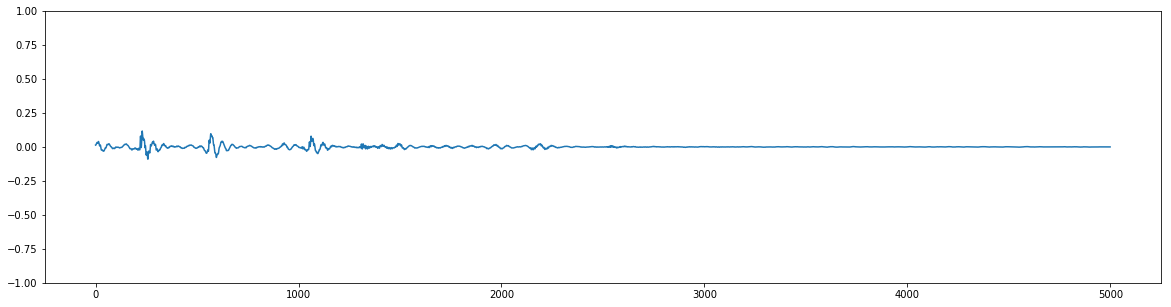

Signal End:

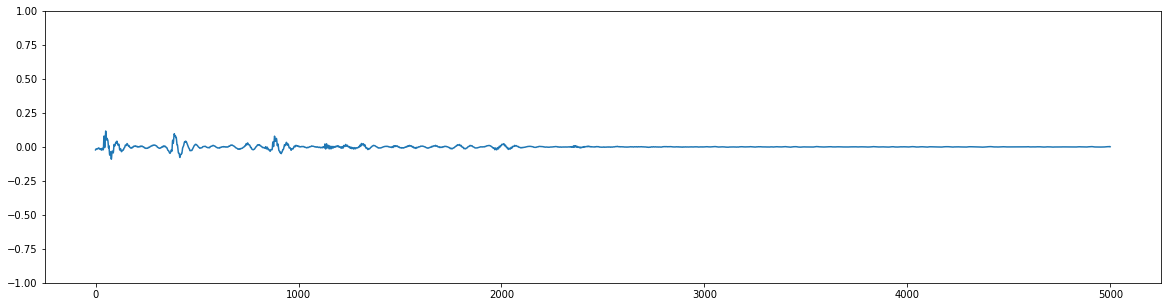

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ041-0057-24000.wav

Text: His study of Communist literature,

Energy Difference: 0.000888

Length Difference: 33

Trimmed End:

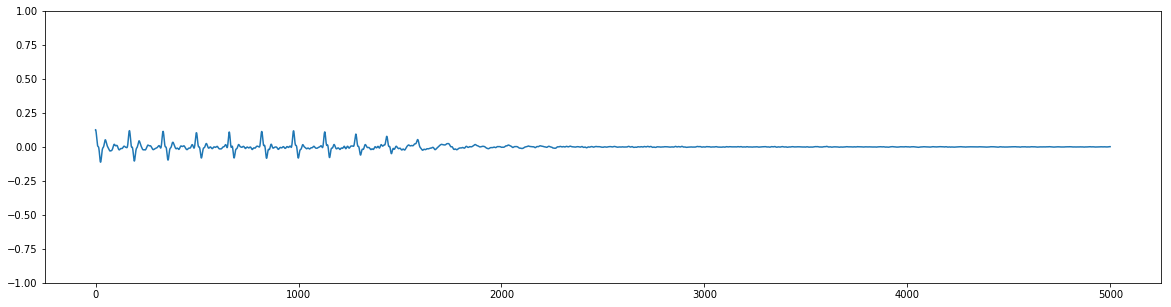

Signal End:

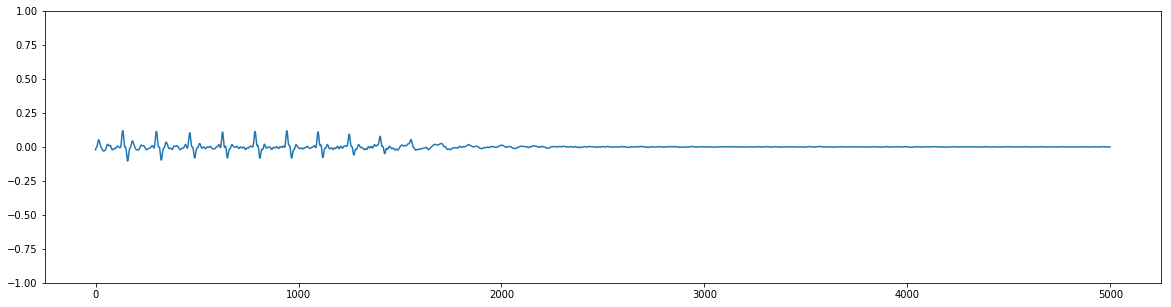

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ040-0051-24000.wav

Text: While there is doubt about how fully Oswald understood the doctrine which he so often espoused, it seems clear

Energy Difference: 0.000885

Length Difference: 771

Trimmed End:

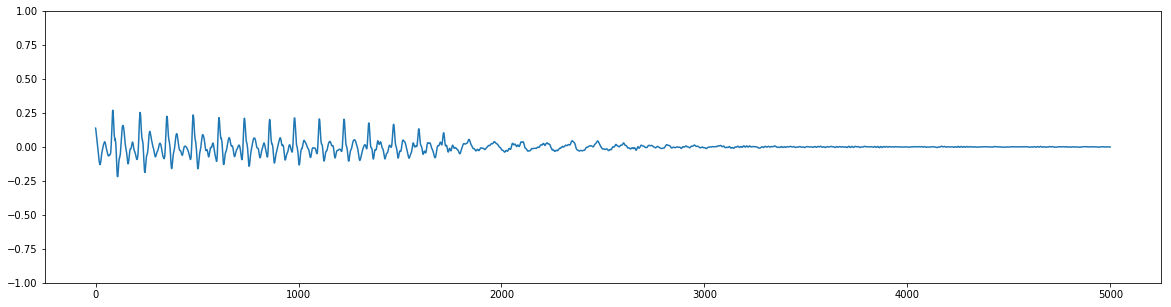

Signal End:

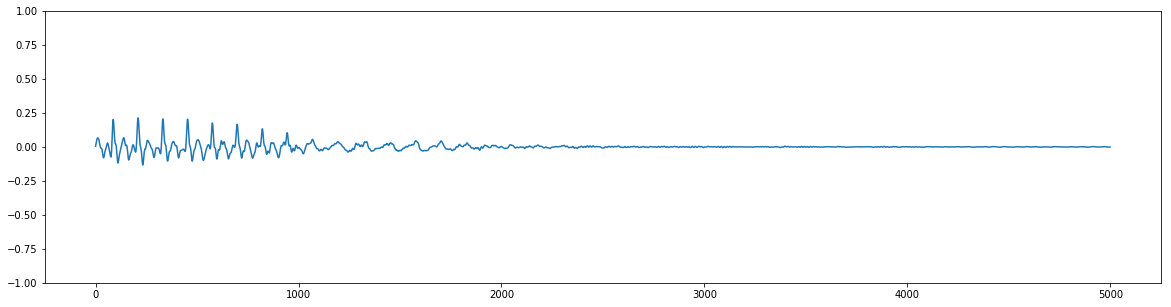

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ018-0067-24000.wav

Text: Thither, he was pursued by a detective officer,

Energy Difference: 0.000868

Length Difference: 639

Trimmed End:

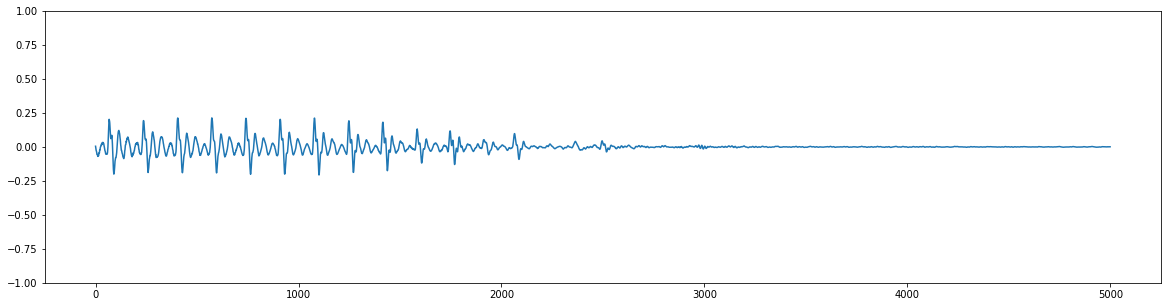

Signal End:

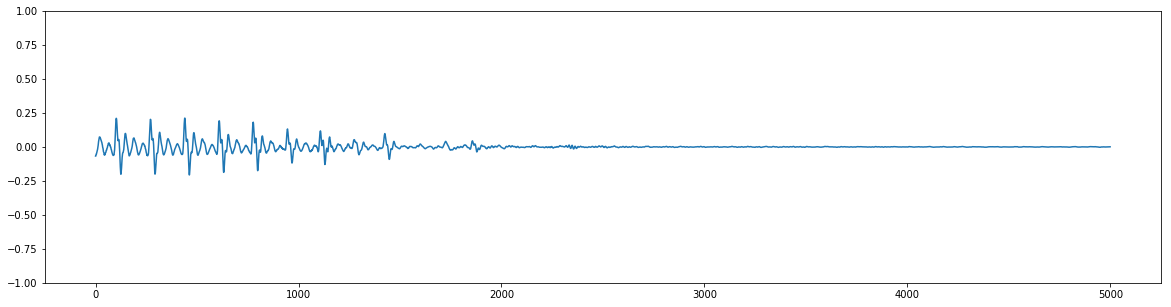

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ028-0272-24000.wav

Text: All stratagems and all arts had been used, and yet the King could not prevail

Energy Difference: 0.000866

Length Difference: 203

Trimmed End:

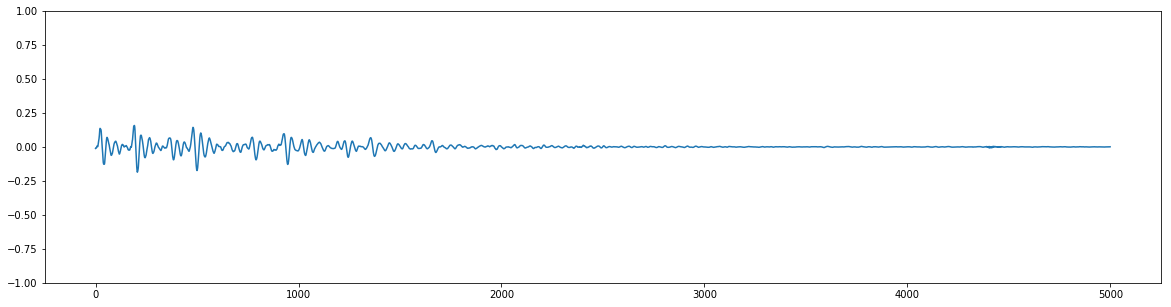

Signal End:

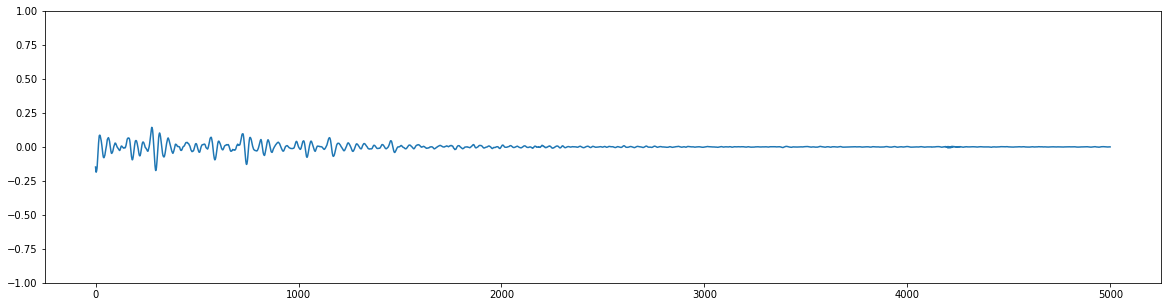

---

File: /Users/michaelp/Code/WellSaid-Labs-Text-To-Speech/data/LJSpeech-1.1/wavs/LJ029-0117-24000.wav

Text: According to Lawson, the chosen route seemed to be the best.

Energy Difference: 0.000860

Length Difference: 23

Trimmed End:

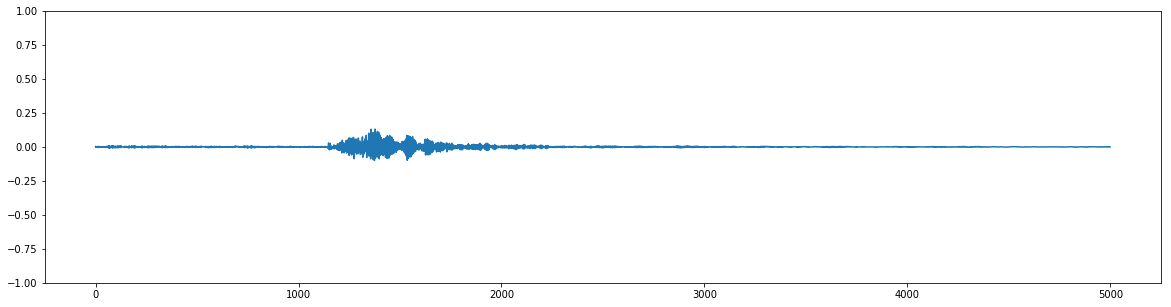

Signal End:

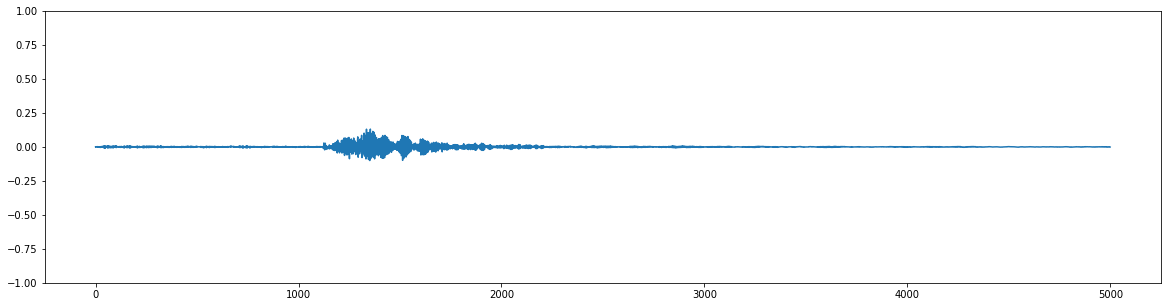

---

In [14]:
import sys
import librosa

trim = lambda _, s: librosa.effects.trim(s, frame_length=1200, hop_length=300, top_db=50)[0]

evaluate_trim(trim, top_k=20, max_rows=sys.maxsize)

## PyDub

In [17]:
import pydub
from pydub import AudioSegment

def pydub_trim(wav, _):
    sound = AudioSegment.from_wav(wav)
    pydub.effects.strip_silence(sound)
    return sound.get_array_of_samples()

evaluate_trim(pydub_trim)

100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s]


### Top 5 Signals Affected by Trim

## SOX

Reference:
https://digitalcardboard.com/blog/2009/08/25/the-sox-of-silence/

100%|██████████| 1000/1000 [00:19<00:00, 51.88it/s]


### Top 5 Signals Affected by Trim

File: ../data/LJSpeech-1.1/wavs/LJ028-0060.wav

Energy Difference: 0.009511

Length Difference: 4475

Trimmed Start:

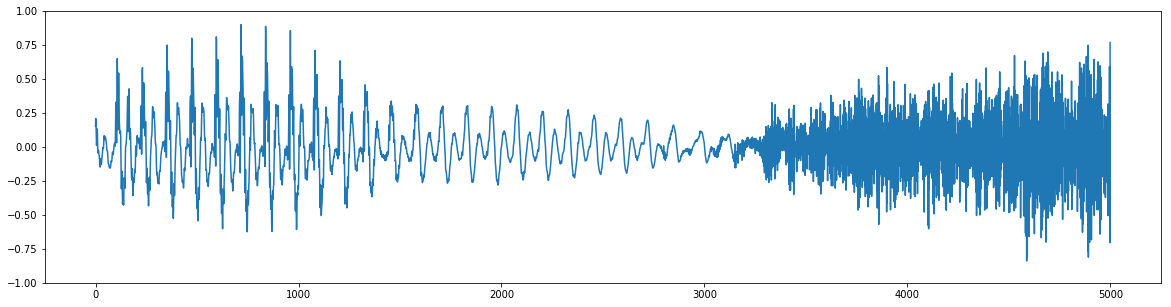

Signal Start:

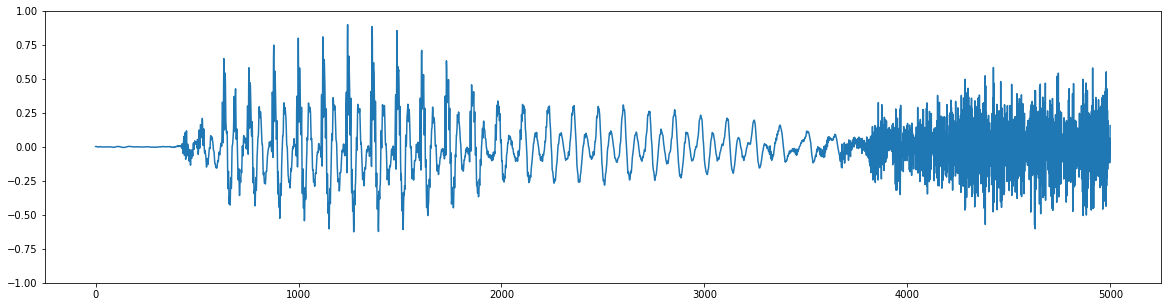

Trimmed End:

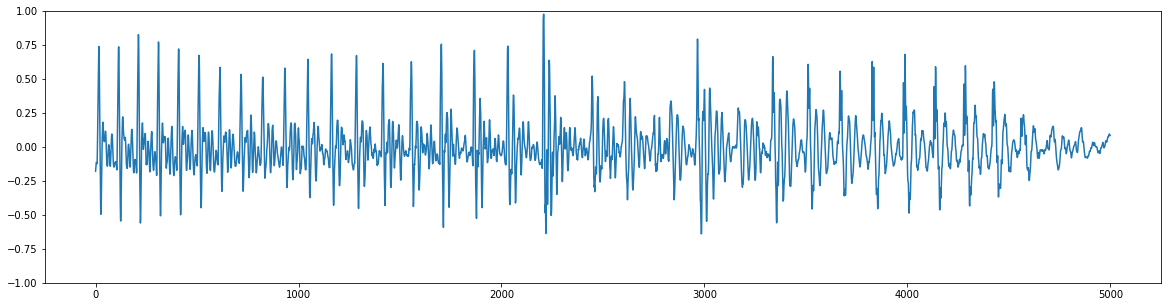

Signal End:

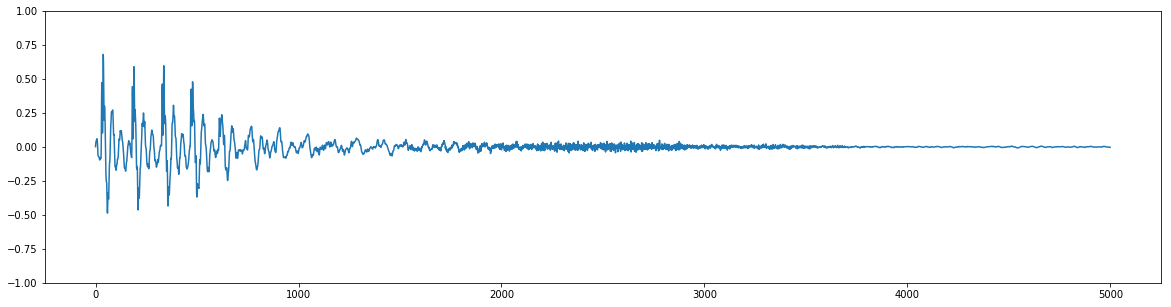

---

File: ../data/LJSpeech-1.1/wavs/LJ037-0133.wav

Energy Difference: 0.008810

Length Difference: 4642

Trimmed Start:

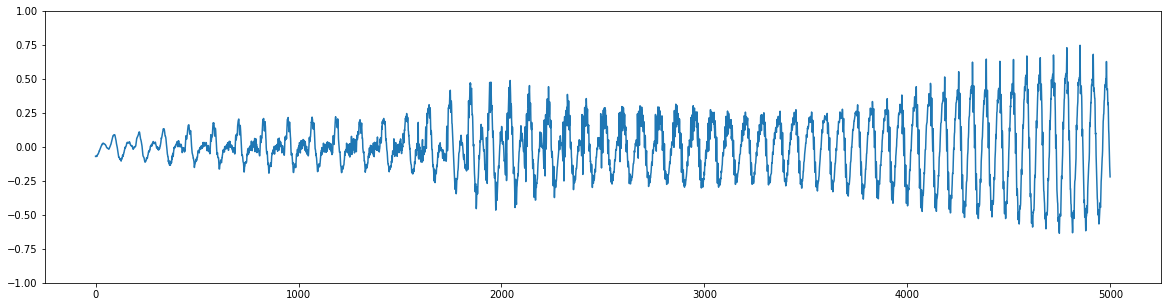

Signal Start:

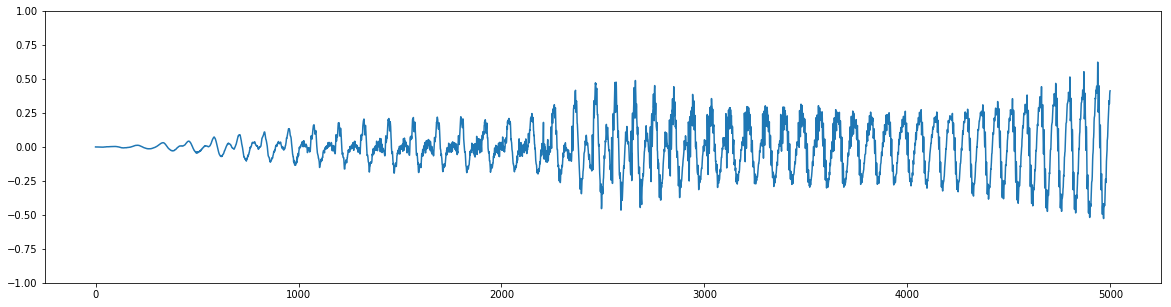

Trimmed End:

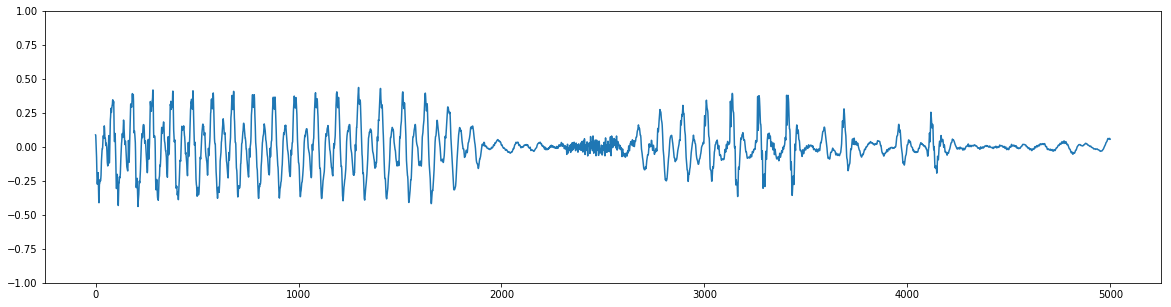

Signal End:

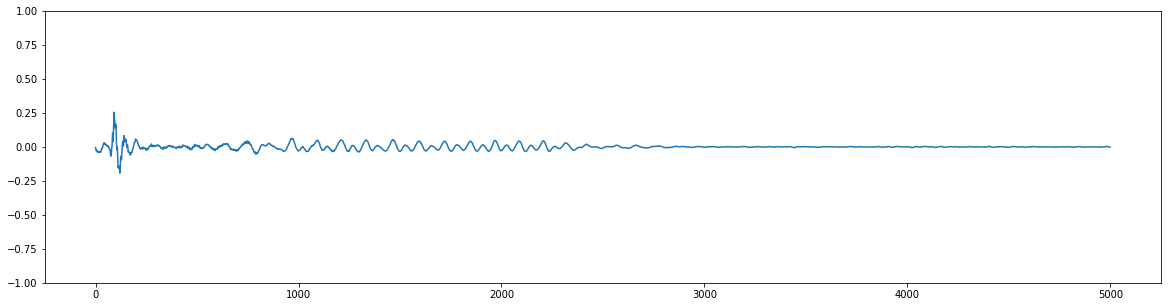

---

File: ../data/LJSpeech-1.1/wavs/LJ024-0102.wav

Energy Difference: 0.008670

Length Difference: 3455

Trimmed Start:

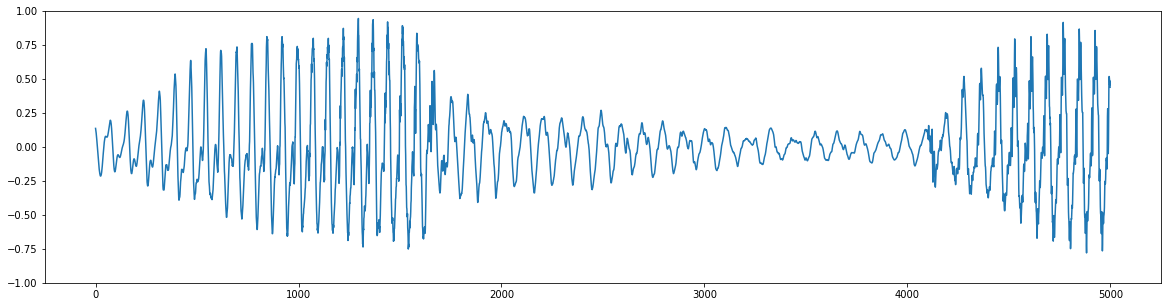

Signal Start:

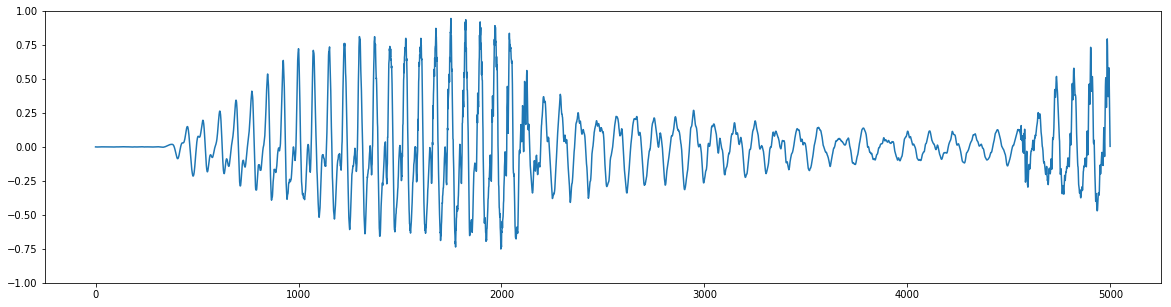

Trimmed End:

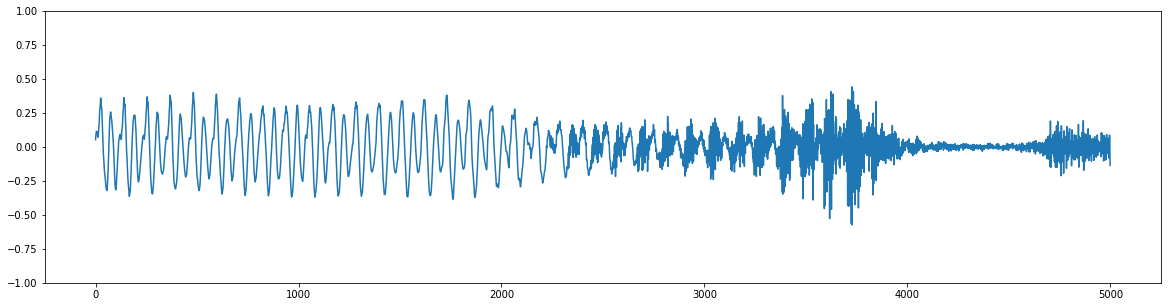

Signal End:

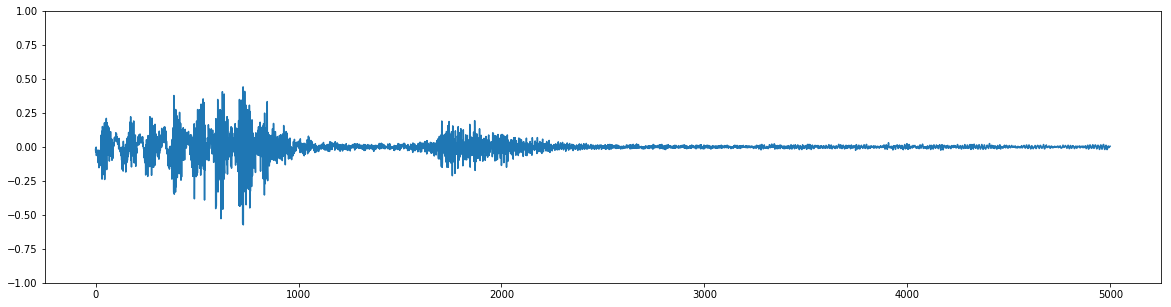

---

File: ../data/LJSpeech-1.1/wavs/LJ008-0110.wav

Energy Difference: 0.008669

Length Difference: 4608

Trimmed Start:

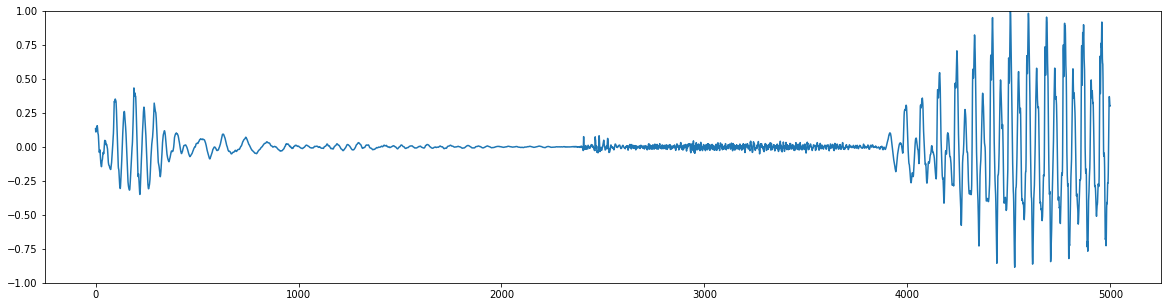

Signal Start:

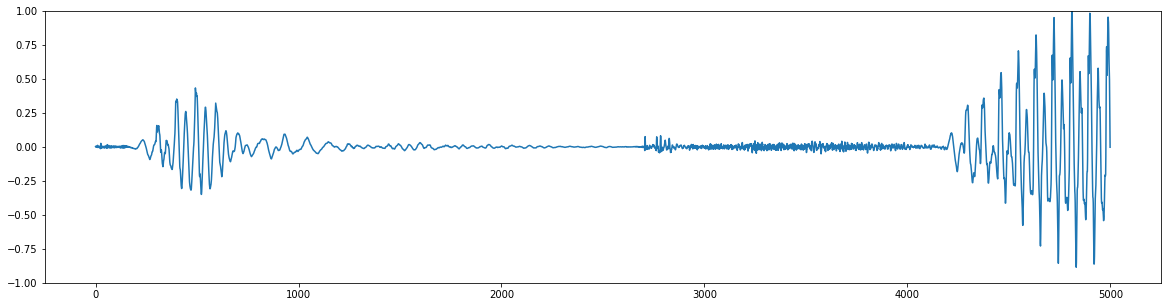

Trimmed End:

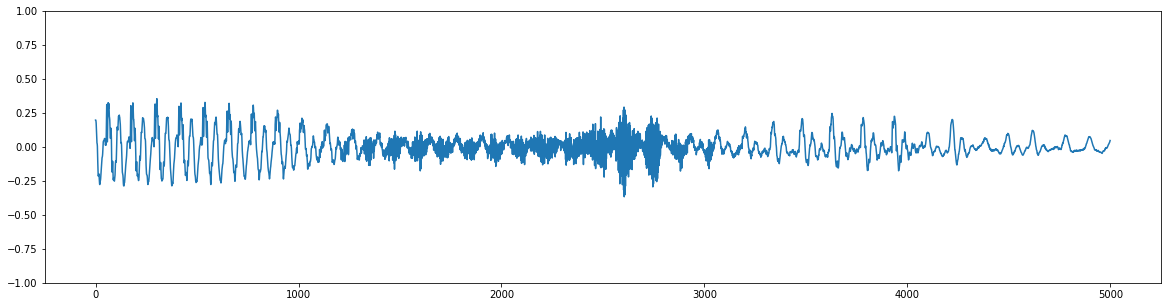

Signal End:

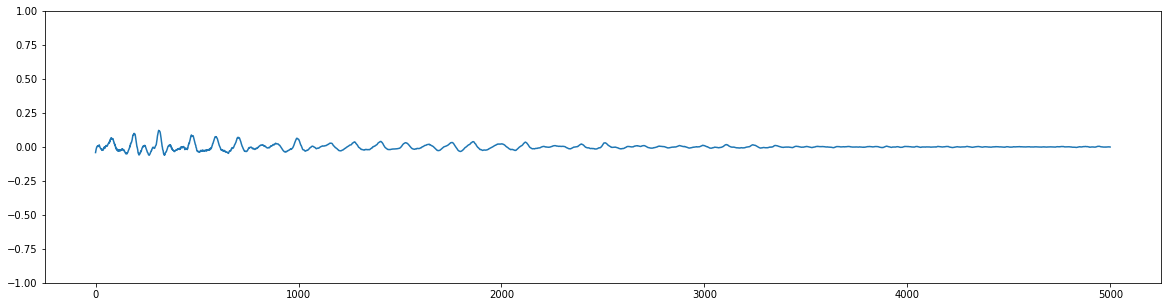

---

File: ../data/LJSpeech-1.1/wavs/LJ009-0077.wav

Energy Difference: 0.008613

Length Difference: 4474

Trimmed Start:

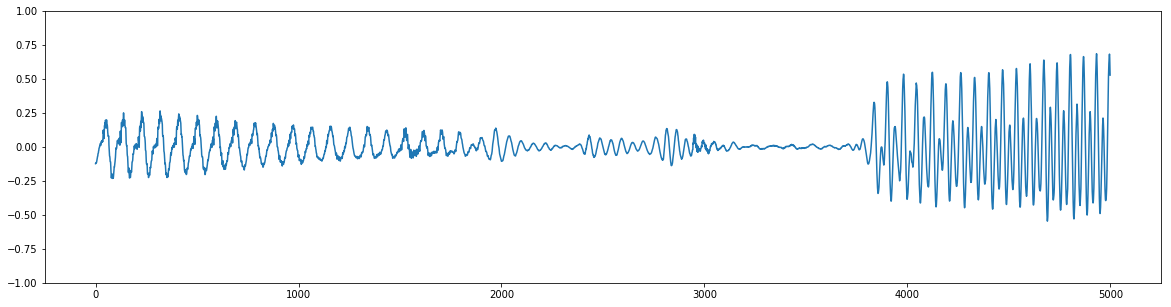

Signal Start:

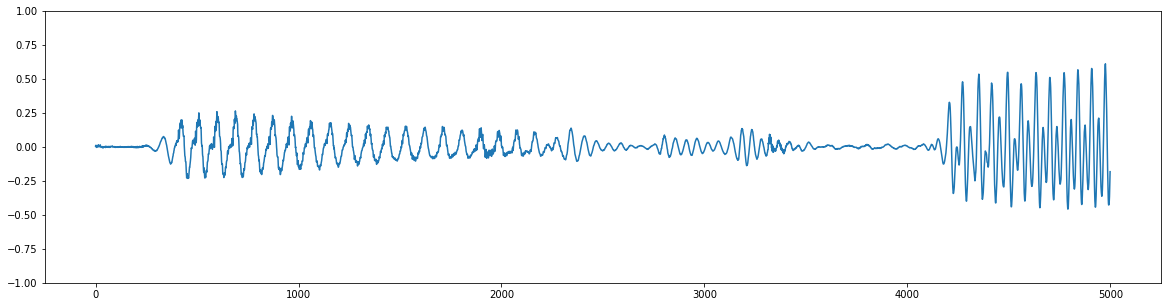

Trimmed End:

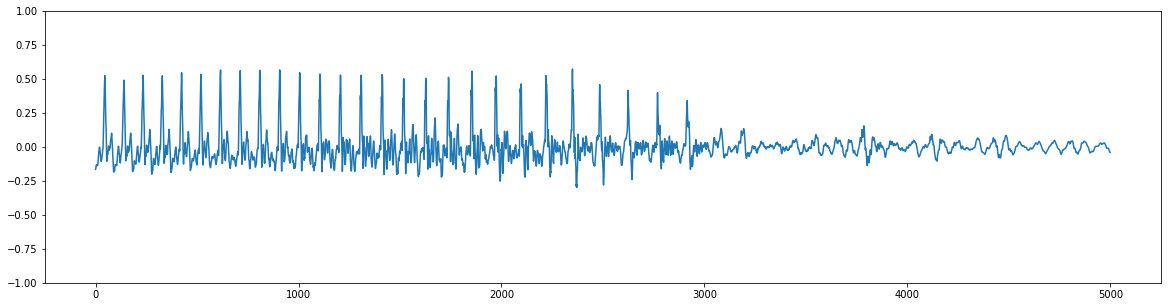

Signal End:

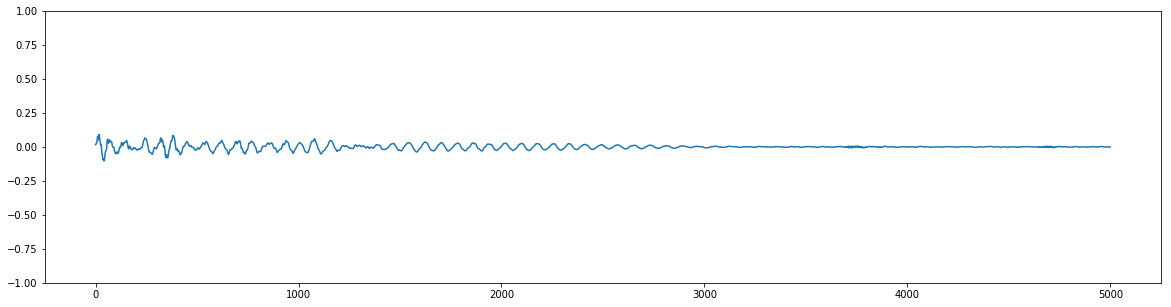

---

In [20]:
import os

destination = os.path.abspath('temp.wav')
    
def sox_trim(wav, _):
    os.system('sox {} {} silence 1 0.01 1% reverse silence 1 0.01 1% reverse'.format(wav, destination))
    trimmed = read_audio(destination)
    return trimmed

evaluate_trim(sox_trim)

# Clean up
os.remove(destination)
assert not os.path.isfile(destination)

## ibab/tensorflow-wavenet



100%|██████████| 1000/1000 [00:05<00:00, 188.14it/s]


### Top 5 Signals Affected by Trim

File: ../data/LJSpeech-1.1/wavs/LJ024-0116.wav

Energy Difference: 0.048503

Length Difference: 8349

Trimmed Start:

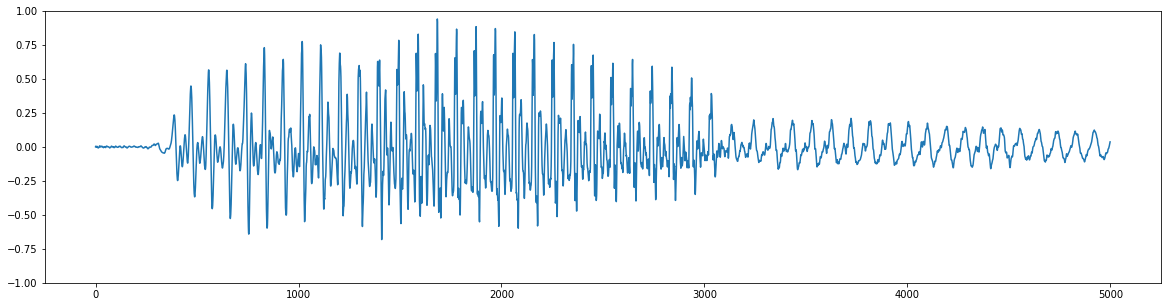

Signal Start:

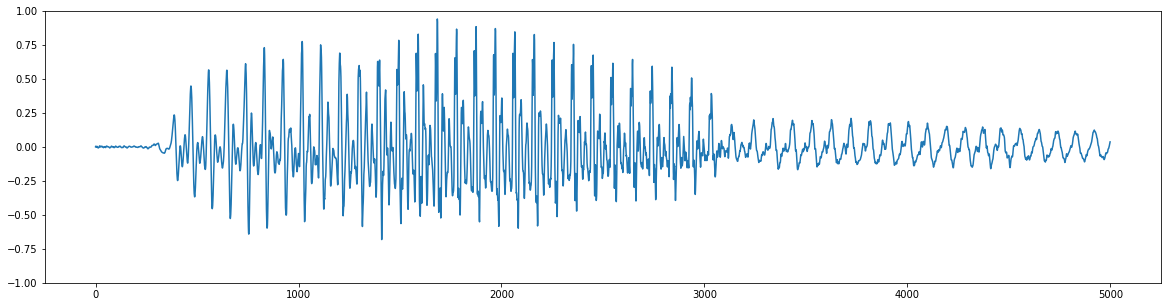

Trimmed End:

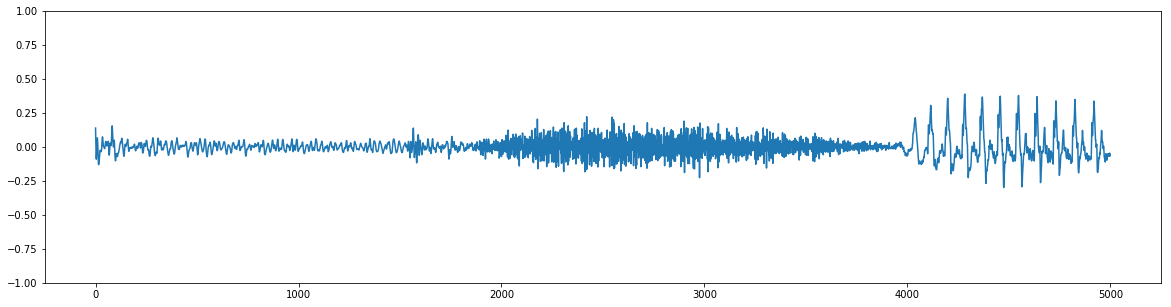

Signal End:

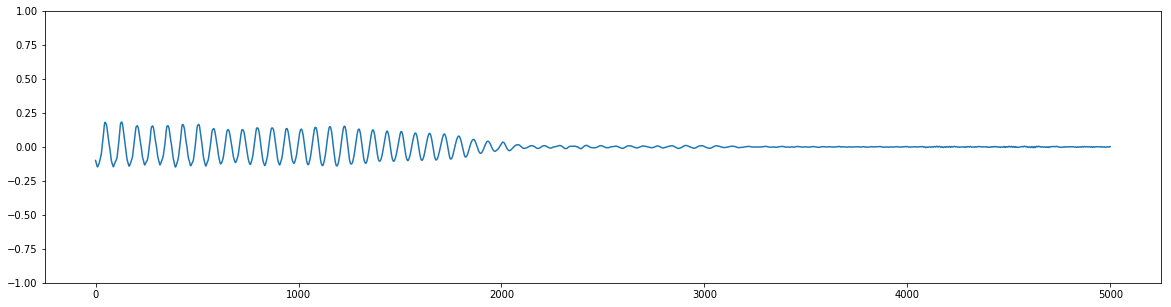

---

File: ../data/LJSpeech-1.1/wavs/LJ013-0014.wav

Energy Difference: 0.045640

Length Difference: 14749

Trimmed Start:

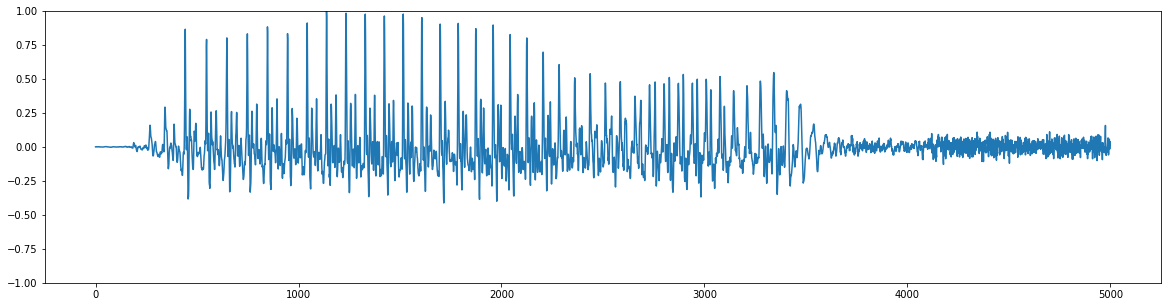

Signal Start:

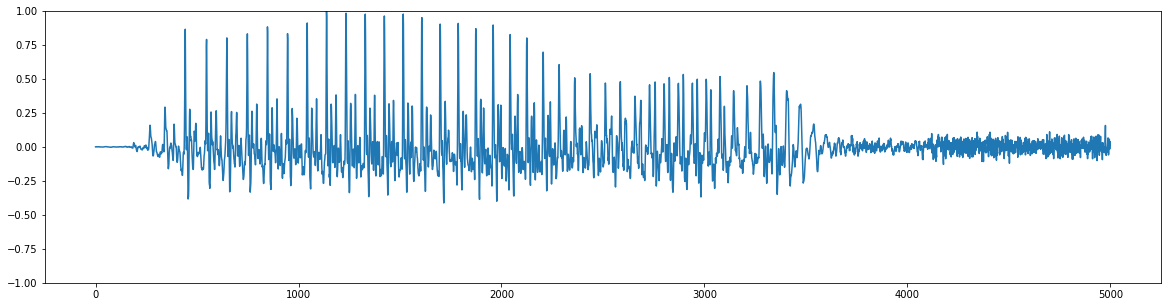

Trimmed End:

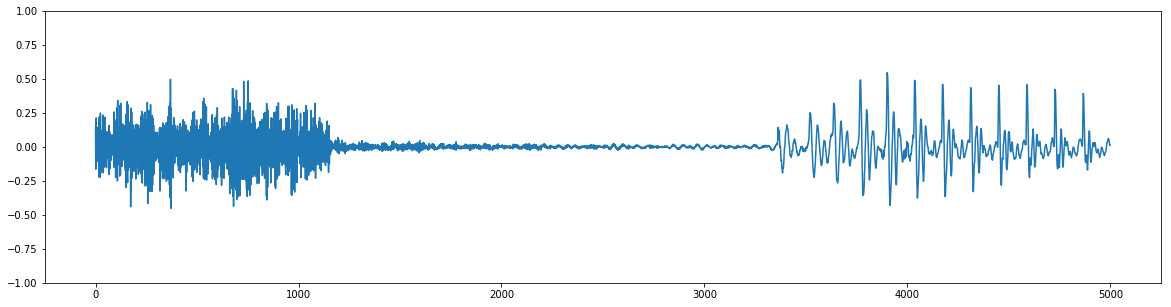

Signal End:

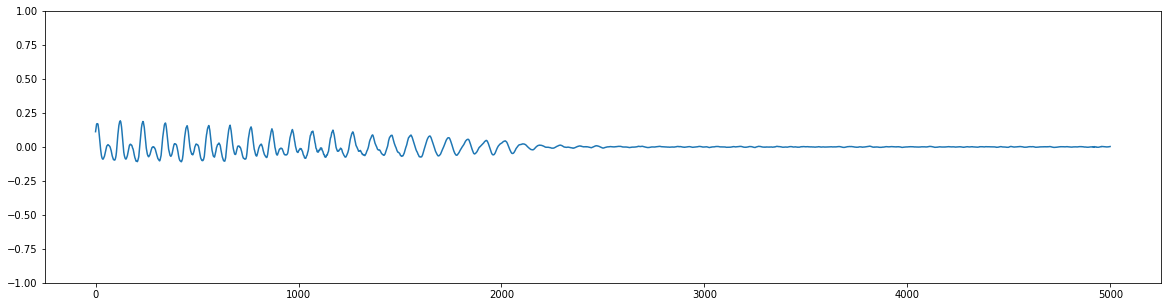

---

File: ../data/LJSpeech-1.1/wavs/LJ024-0019.wav

Energy Difference: 0.044114

Length Difference: 19613

Trimmed Start:

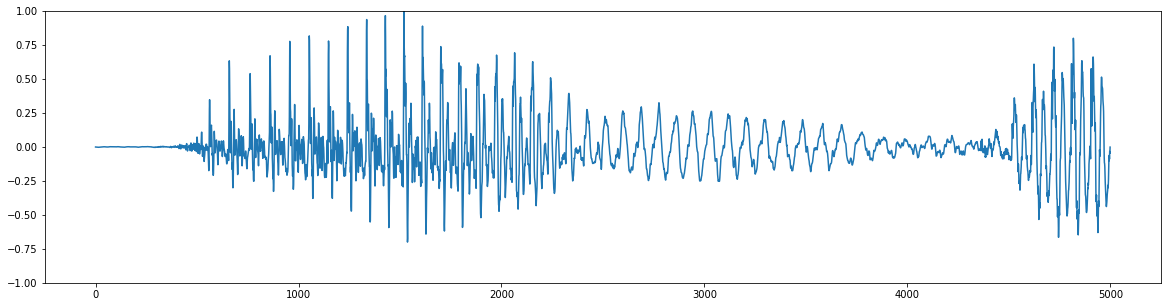

Signal Start:

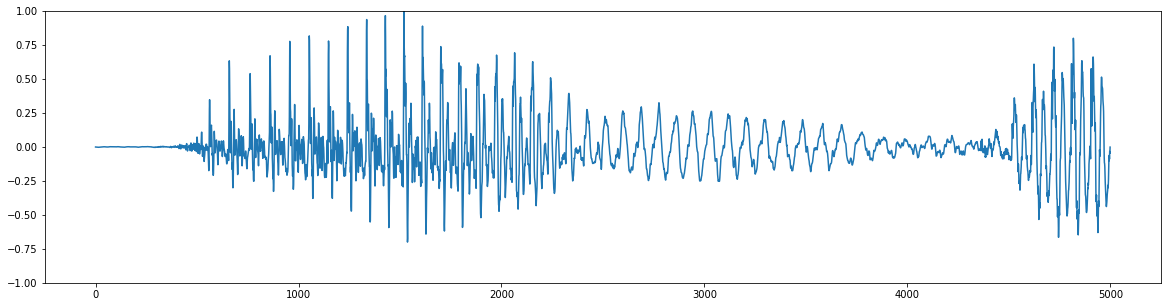

Trimmed End:

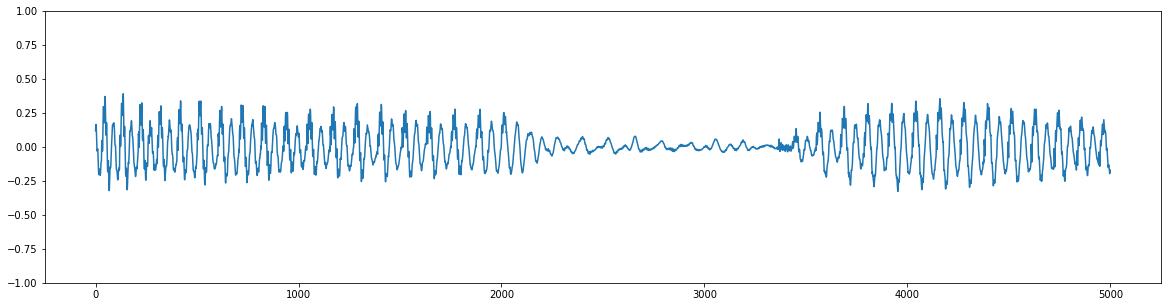

Signal End:

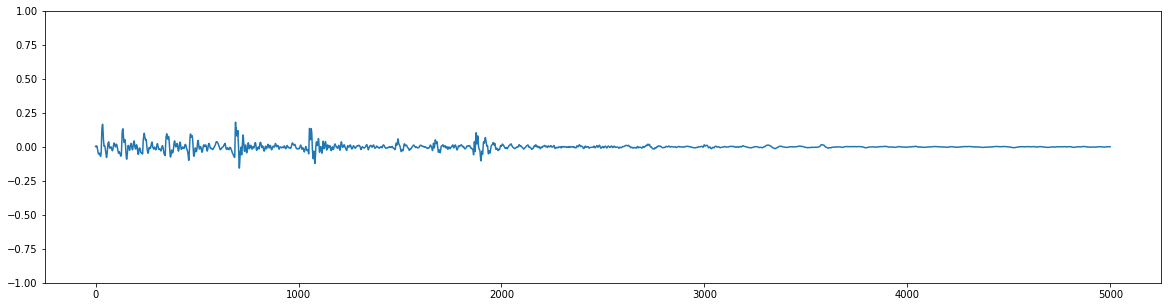

---

File: ../data/LJSpeech-1.1/wavs/LJ048-0170.wav

Energy Difference: 0.041882

Length Difference: 18845

Trimmed Start:

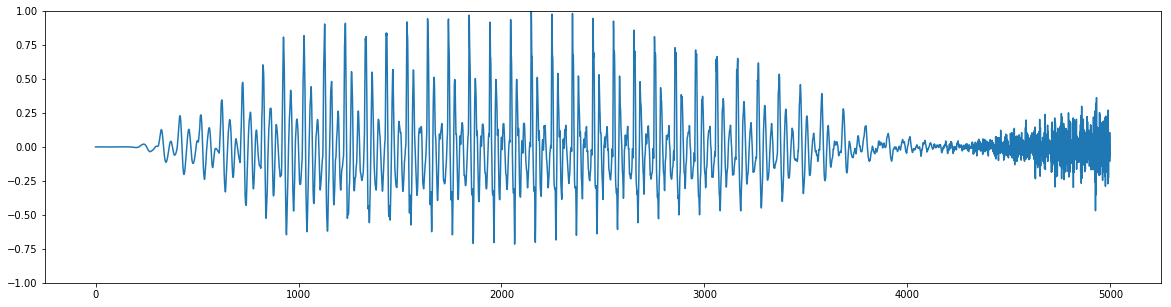

Signal Start:

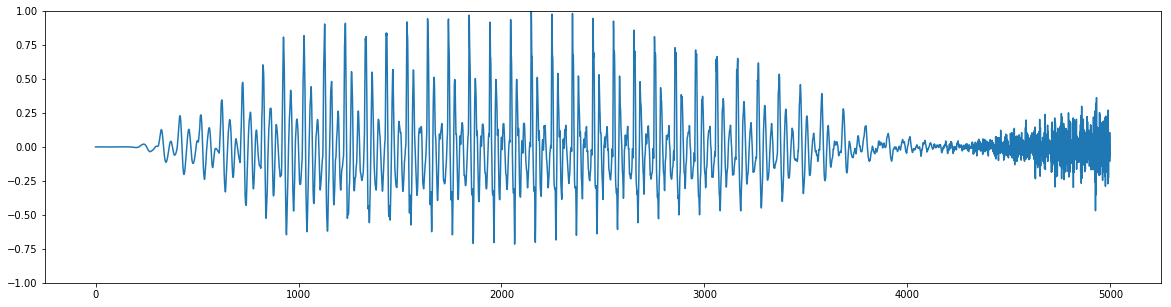

Trimmed End:

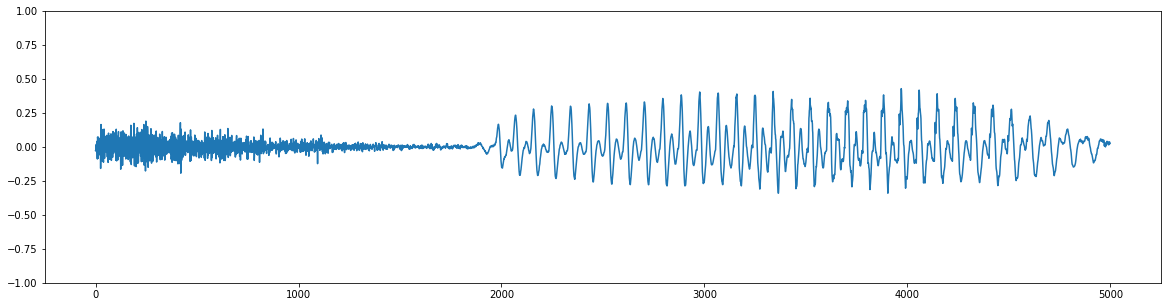

Signal End:

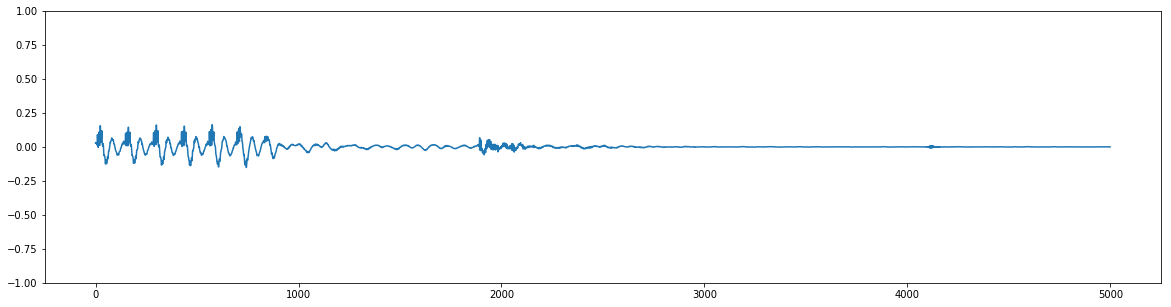

---

File: ../data/LJSpeech-1.1/wavs/LJ028-0392.wav

Energy Difference: 0.041735

Length Difference: 12445

Trimmed Start:

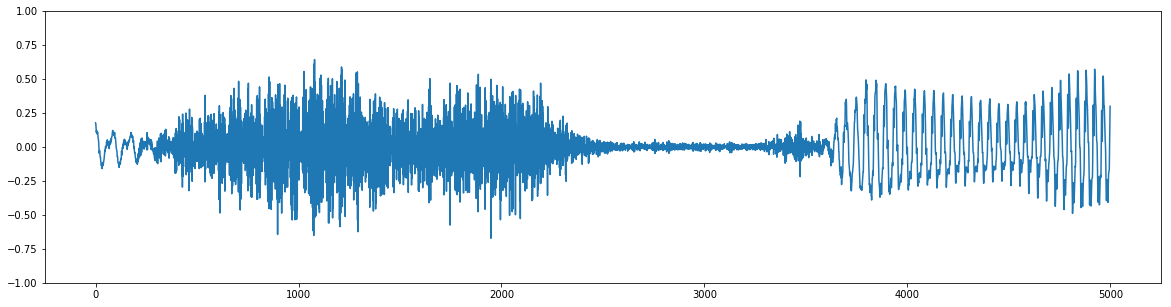

Signal Start:

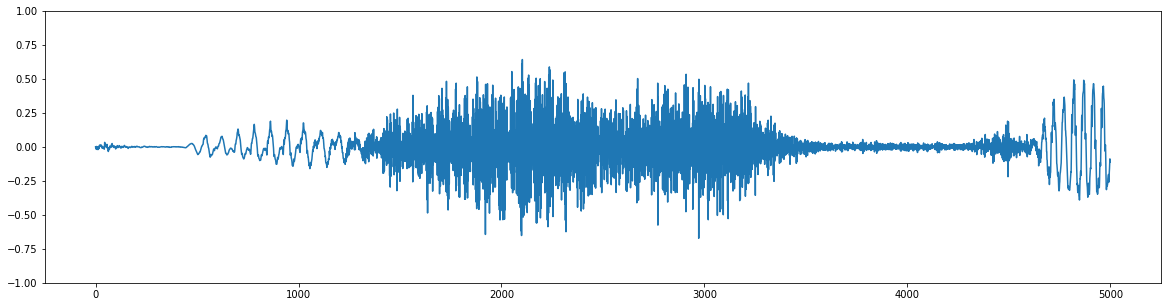

Trimmed End:

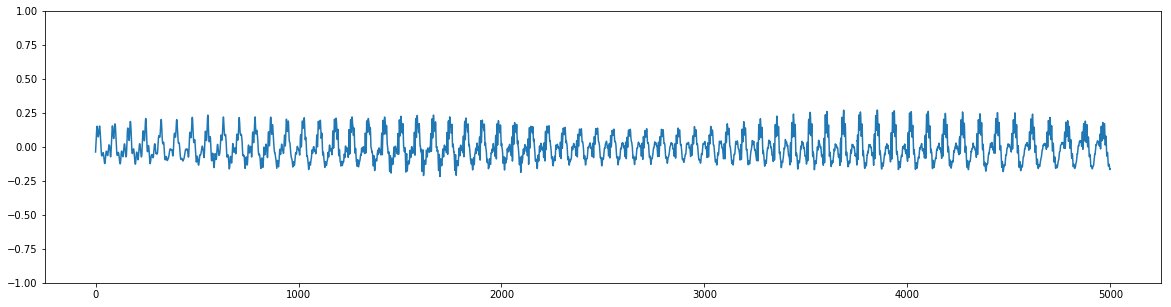

Signal End:

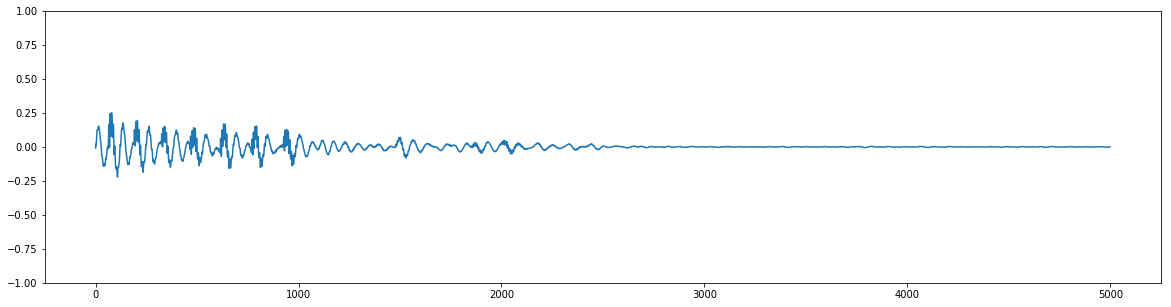

---

In [30]:
def trim_silence(_, audio, threshold=0.1, frame_length=2048):
    '''Removes silence at the beginning and end of a sample.'''
    audio = np.array(audio, dtype=np.float)
    if audio.size < frame_length:
        frame_length = audio.size
    energy = librosa.feature.rmse(audio, frame_length=frame_length)
    frames = np.nonzero(energy > threshold)
    indices = librosa.core.frames_to_samples(frames)[1]

    # Note: indices can be an empty array, if the whole audio was silence.
    return audio[indices[0]:indices[-1]] if indices.size else audio[0:0]

evaluate_trim(trim_silence)